In [0]:
## Code from https://github.com/nikitaa30/Manga-GAN/blob/master/anime-facegan.py
## Which showcases how it is done on anime faces, trying on league of legends champs


from __future__ import print_function, division 

from keras.layers import Input, Dense, Flatten, Dropout, Reshape, merge
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.models import Model, load_model 
from keras.optimizers import SGD, Adam, RMSprop
#from misc_layers import MinibatchDiscrimination, SubPixelUpscaling, CustomLRELU, bilinear2x
#from keras_contrib.layers import SubPixelUpscaling
import keras.backend as K 
from keras.initializers import RandomNormal

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle
import numpy as np
import sys
import time 
import os 
import glob
import tqdm 
from PIL import Image
from collections import deque
os.environ["KERAS_BACKEND"] = "tensorflow"

In [0]:
def get_generator(noise_shape):
    kernel_init = 'glorot_uniform'
    gen_input = Input(shape=noise_shape)

    generator = Conv2DTranspose(filters=512, kernel_size=(4,4), strides=(1,1), padding="valid", data_format="channels_last", kernel_initializer=kernel_init)(gen_input)
    generator = BatchNormalization(momentum=0.5)(generator)
    generator = LeakyReLU(0.2)(generator)
        
    generator = Conv2DTranspose(filters=256, kernel_size=(4,4), strides=(2,2), padding="same", data_format="channels_last", kernel_initializer=kernel_init)(generator)
    generator = BatchNormalization(momentum=0.5)(generator)
    generator = LeakyReLU(0.2)(generator)
    
    generator = Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding="same", data_format="channels_last", kernel_initializer=kernel_init)(generator)
    generator = BatchNormalization(momentum=0.5)(generator)
    generator = LeakyReLU(0.2)(generator)
    
    generator = Conv2DTranspose(filters=64, kernel_size=(4,4), strides=(2,2), padding="same", data_format="channels_last", kernel_initializer=kernel_init)(generator)
    generator = BatchNormalization(momentum=0.5)(generator)
    generator = LeakyReLU(0.2)(generator)
    ## Try Conv2DTranpose to see if it makes a difference with 4,4 Kernal 
    generator = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same", data_format="channels_last", kernel_initializer=kernel_init)(generator)
    generator = BatchNormalization(momentum=0.5)(generator)
    generator = LeakyReLU(0.2)(generator)
    
    generator = Conv2DTranspose(filters=3, kernel_size=(4,4), strides=(2,2), padding="same", data_format="channels_last", kernel_initializer=kernel_init)(generator)
    generator = Activation('tanh')(generator)

    gen_opt = Adam(lr=0.00015, beta_1=0.5)
    generator_model = Model(input=gen_input, output=generator)
    generator_model.compile(loss='binary_crossentropy', optimizer=gen_opt, metrics=['accuracy'])
    generator_model.summary()

    return generator_model

In [0]:
def get_discriminator(image_shape=(64, 64, 3)):
  dropout_prob = 0.4 
  kernel_init = 'glorot_uniform'
  disc_input = Input(shape=image_shape)

  discriminator = Conv2D(filters=64, kernel_size=(4,4), strides=(2,2), padding="same", data_format="channels_last", kernel_initializer=kernel_init)(disc_input)
  discriminator = LeakyReLU(0.2)(discriminator)
  discriminator = Conv2D(filters=128, kernel_size=(4,4), strides=(2,2), padding="same", data_format="channels_last", kernel_initializer=kernel_init)(discriminator)
  discriminator = BatchNormalization(momentum=0.5)(discriminator)
  discriminator = LeakyReLU(0.2)(discriminator)

  discriminator = Conv2D(filters=256, kernel_size=(4,4), strides=(2,2), padding="same", data_format="channels_last", kernel_initializer=kernel_init)(discriminator)
  discriminator = BatchNormalization(momentum=0.5)(discriminator)
  discriminator = LeakyReLU(0.2)(discriminator)
    
  discriminator = Conv2D(filters=512, kernel_size=(4,4), strides=(2,2), padding="same", data_format="channels_last", kernel_initializer=kernel_init)(discriminator)
  discriminator = BatchNormalization(momentum=0.5)(discriminator)
  discriminator = LeakyReLU(0.2)(discriminator)
    
  discriminator = Flatten()(discriminator)

  discriminator = Dense(1)(discriminator)
  discriminator = Activation('sigmoid')(discriminator)
  ## Also try SGD
  dis_opt = Adam(lr=0.002, beta_1=0.5)
  discriminator_model = Model(input=disc_input, output=discriminator)
  discriminator_model.compile(loss='binary_crossentropy', optimizer=dis_opt, metrics=['accuracy'])
  discriminator_model.summary()

  return discriminator_model

In [0]:
def normalize_img(img): 
  return (img / 127.5) - 1

def denorm_img(img): 
  img = (img + 1) * 127.5
  return img.astype(np.uint8)

In [0]:
def sample_from_dataset(batch_size, image_shape, data_dir=None, data=None):
  sample_dim = (batch_size,) + image_shape
  sample = np.empty(sample_dim, dtype=np.float32)
  all_data_dirlist = list(glob.glob(data_dir))
  sample_img_paths = np.random.choice(all_data_dirlist, batch_size)
  for index, img_filename in enumerate(sample_img_paths):
    image = Image.open(img_filename)
    image = image.resize(image_shape[:-1])
    image = image.convert('RGB')
    image = np.asarray(image)
    image = normalize_img(image)
    sample[index,...] = image
  return sample

In [0]:
def gen_noise(batch_size, noise_shape): 
  return np.random.normal(0, 1, size=(batch_size,) + noise_shape)

def generate_images(generator, save_dir):
  noise = gen_noise(batch_size, noise_shape)
  fake_data_X = generator.predict(noise)
  print("Displaying generated images")
  plt.figure(figsize=(4, 4))
  gs1 = gridspec.GridSpec(4, 4)
  gs1.update(wspace=0, hspace=0)
  rand_indices = np.random.choice(fake_data_X.shape[0],16,replace=False)
  for i in range(16):
    #plt.subplot(4, 4, i+1)
    ax1 = plt.subplot(gs1[i])
    ax1.set_aspect('equal')
    rand_index = rand_indices[i]
    image = fake_data_X[rand_index, :,:,:]
    fig = plt.imshow(denorm_img(image))
    plt.axis('off')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
  plt.tight_layout()
  plt.savefig(save_dir + str(time.time()) + "_GENimage.png", bbox_inches='tight', pad_inches=0)
  plt.show()

In [0]:
def save_img_batch(img_batch, img_save_dir): 
  plt.figure(figsize=(4,4))
  gs1 = gridspec.GridSpec(4, 4)
  gs1.update(wspace=0, hspace=0)
  rand_indices = np.random.choice(img_batch.shape[0], 16, replace=False)
  for i in range(16):
    #plt.subplot(4, 4, i+1)
    ax1 = plt.subplot(gs1[i])
    ax1.set_aspect('equal')
    rand_index = rand_indices[i]
    image = img_batch[rand_index, :,:,:]
    fig = plt.imshow(denorm_img(image))
    plt.axis('off')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
  plt.tight_layout()
  plt.savefig(img_save_dir,bbox_inches='tight',pad_inches=0)
  plt.show()

In [0]:
pwd


'/content'

In [0]:
noise_shape = (1, 1, 100)
num_steps = 10000
batch_size = 64
image_save_dir = '/content/output'
save_model = True
image_shape = (64, 64, 3)
data_dir = '/content/data/*.jpg'
log_dir = image_save_dir
save_model_dir = image_save_dir

In [0]:
discriminator = get_discriminator(image_shape)
generator = get_generator(noise_shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu_109 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 16, 16, 128)       131200    
_________________________________________________________________
batch_normalization_97 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_110 (LeakyReLU)  (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 8, 8, 256)         524

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


In [0]:
discriminator.trainable = False

opt = Adam(lr=0.00015, beta_1=0.5) 
gen_inp = Input(shape=noise_shape)
GAN_inp = generator(gen_inp)
GAN_opt = discriminator(GAN_inp)
gan = Model(input = gen_inp, output = GAN_opt)
gan.compile(loss = 'binary_crossentropy', optimizer = opt, metrics=['accuracy'])
gan.summary()

Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        (None, 1, 1, 100)         0         
_________________________________________________________________
model_38 (Model)             (None, 64, 64, 3)         3616771   
_________________________________________________________________
model_37 (Model)             (None, 1)                 2768321   
Total params: 6,385,092
Trainable params: 3,614,723
Non-trainable params: 2,770,369
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("mo...)`
  import sys


In [0]:
avg_disc_fake_loss = deque([0], maxlen=250)     
avg_disc_real_loss = deque([0], maxlen=250)
avg_GAN_loss = deque([0], maxlen=250)

Begin step:  0


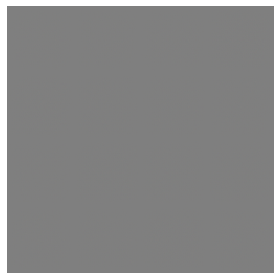

Disc: real loss: 1.114484 fake loss: 14.420938
GAN loss: 1.482977
Step 0 completed. Time took: 17 secs.
Begin step:  1
Disc: real loss: 1.556659 fake loss: 14.511017
GAN loss: 1.556659
Step 1 completed. Time took: 0 secs.
Begin step:  2
Disc: real loss: 1.745783 fake loss: 14.237261
GAN loss: 1.745783
Step 2 completed. Time took: 0 secs.
Begin step:  3
Disc: real loss: 1.675782 fake loss: 14.353926
GAN loss: 1.675782
Step 3 completed. Time took: 0 secs.
Begin step:  4
Disc: real loss: 1.409454 fake loss: 14.478027
GAN loss: 1.409454
Step 4 completed. Time took: 0 secs.
Begin step:  5
Disc: real loss: 1.615219 fake loss: 14.482355
GAN loss: 1.615219
Step 5 completed. Time took: 0 secs.
Begin step:  6
Disc: real loss: 1.699027 fake loss: 14.397278
GAN loss: 1.699027
Step 6 completed. Time took: 0 secs.
Begin step:  7
Disc: real loss: 1.615658 fake loss: 14.311896
GAN loss: 1.615658
Step 7 completed. Time took: 0 secs.
Begin step:  8
Disc: real loss: 1.634852 fake loss: 14.467354
GAN loss

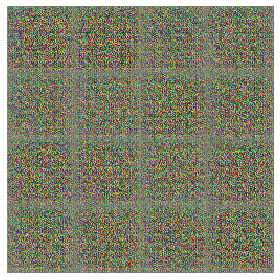

Disc: real loss: 1.684283 fake loss: 14.498990
GAN loss: 1.684283
Step 10 completed. Time took: 1 secs.
Begin step:  11
Disc: real loss: 1.838689 fake loss: 14.252029
GAN loss: 1.838689
Step 11 completed. Time took: 0 secs.
Begin step:  12
Disc: real loss: 1.646632 fake loss: 14.484906
GAN loss: 1.646632
Step 12 completed. Time took: 0 secs.
Begin step:  13
Disc: real loss: 1.626153 fake loss: 14.389621
GAN loss: 1.626153
Step 13 completed. Time took: 0 secs.
Begin step:  14
Disc: real loss: 1.693089 fake loss: 14.445451
GAN loss: 1.693089
Step 14 completed. Time took: 0 secs.
Begin step:  15
Disc: real loss: 1.627593 fake loss: 14.437984
GAN loss: 1.627593
Step 15 completed. Time took: 0 secs.
Begin step:  16
Disc: real loss: 1.476214 fake loss: 14.292136
GAN loss: 1.476214
Step 16 completed. Time took: 0 secs.
Begin step:  17
Disc: real loss: 1.481399 fake loss: 14.345538
GAN loss: 1.481399
Step 17 completed. Time took: 0 secs.
Begin step:  18
Disc: real loss: 1.454878 fake loss: 14.

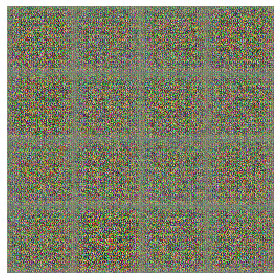

Disc: real loss: 1.567513 fake loss: 14.525849
GAN loss: 1.567513
Step 20 completed. Time took: 0 secs.
Begin step:  21
Disc: real loss: 1.511138 fake loss: 14.376779
GAN loss: 1.511138
Step 21 completed. Time took: 0 secs.
Begin step:  22
Disc: real loss: 1.650265 fake loss: 14.158495
GAN loss: 1.650265
Step 22 completed. Time took: 0 secs.
Begin step:  23
Disc: real loss: 1.613093 fake loss: 14.424891
GAN loss: 1.613093
Step 23 completed. Time took: 0 secs.
Begin step:  24
Disc: real loss: 1.606859 fake loss: 14.372732
GAN loss: 1.606859
Step 24 completed. Time took: 0 secs.
Begin step:  25
Disc: real loss: 1.653610 fake loss: 14.405130
GAN loss: 1.653610
Step 25 completed. Time took: 0 secs.
Begin step:  26
Disc: real loss: 1.628294 fake loss: 14.321703
GAN loss: 1.628294
Step 26 completed. Time took: 0 secs.
Begin step:  27
Disc: real loss: 1.643844 fake loss: 14.272375
GAN loss: 1.643844
Step 27 completed. Time took: 0 secs.
Begin step:  28
Disc: real loss: 1.581717 fake loss: 14.

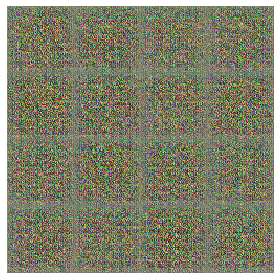

Disc: real loss: 1.767763 fake loss: 14.252153
GAN loss: 1.767763
Step 30 completed. Time took: 0 secs.
Begin step:  31
Disc: real loss: 1.586552 fake loss: 14.282982
GAN loss: 1.586552
Step 31 completed. Time took: 0 secs.
Begin step:  32
Disc: real loss: 1.573772 fake loss: 14.467012
GAN loss: 1.573772
Step 32 completed. Time took: 0 secs.
Begin step:  33
Disc: real loss: 1.686481 fake loss: 14.558281
GAN loss: 1.686481
Step 33 completed. Time took: 0 secs.
Begin step:  34
Disc: real loss: 1.765024 fake loss: 14.247000
GAN loss: 1.765024
Step 34 completed. Time took: 0 secs.
Begin step:  35
Disc: real loss: 1.779871 fake loss: 14.063505
GAN loss: 1.779871
Step 35 completed. Time took: 0 secs.
Begin step:  36
Disc: real loss: 1.488801 fake loss: 14.360657
GAN loss: 1.488801
Step 36 completed. Time took: 0 secs.
Begin step:  37
Disc: real loss: 1.535692 fake loss: 14.239340
GAN loss: 1.535692
Step 37 completed. Time took: 0 secs.
Begin step:  38
Disc: real loss: 1.691608 fake loss: 14.

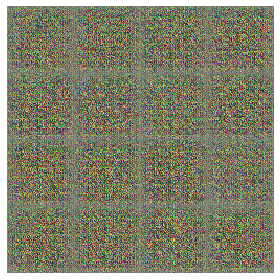

Disc: real loss: 1.519709 fake loss: 14.460211
GAN loss: 1.519709
Step 40 completed. Time took: 0 secs.
Begin step:  41
Disc: real loss: 1.688344 fake loss: 14.289101
GAN loss: 1.688344
Step 41 completed. Time took: 0 secs.
Begin step:  42
Disc: real loss: 1.582434 fake loss: 14.380320
GAN loss: 1.582434
Step 42 completed. Time took: 0 secs.
Begin step:  43
Disc: real loss: 1.604629 fake loss: 14.473127
GAN loss: 1.604629
Step 43 completed. Time took: 0 secs.
Begin step:  44
Disc: real loss: 1.586886 fake loss: 14.352022
GAN loss: 1.586886
Step 44 completed. Time took: 0 secs.
Begin step:  45
Disc: real loss: 1.534644 fake loss: 14.384693
GAN loss: 1.534644
Step 45 completed. Time took: 0 secs.
Begin step:  46
Disc: real loss: 1.602999 fake loss: 14.611580
GAN loss: 1.602999
Step 46 completed. Time took: 0 secs.
Begin step:  47
Disc: real loss: 1.767194 fake loss: 14.251883
GAN loss: 1.767194
Step 47 completed. Time took: 0 secs.
Begin step:  48
Disc: real loss: 1.599180 fake loss: 14.

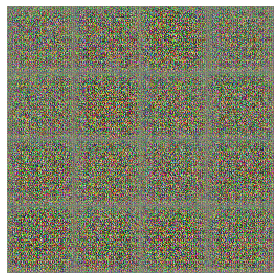

Disc: real loss: 1.609530 fake loss: 14.162047
GAN loss: 1.609530
Step 50 completed. Time took: 0 secs.
Begin step:  51
Disc: real loss: 1.637567 fake loss: 14.197157
GAN loss: 1.637567
Step 51 completed. Time took: 0 secs.
Begin step:  52
Disc: real loss: 1.667719 fake loss: 14.469065
GAN loss: 1.667719
Step 52 completed. Time took: 0 secs.
Begin step:  53
Disc: real loss: 1.642745 fake loss: 14.309649
GAN loss: 1.642745
Step 53 completed. Time took: 0 secs.
Begin step:  54
Disc: real loss: 1.574259 fake loss: 14.282640
GAN loss: 1.574259
Step 54 completed. Time took: 0 secs.
Begin step:  55
Disc: real loss: 1.595724 fake loss: 14.353297
GAN loss: 1.595724
Step 55 completed. Time took: 0 secs.
Begin step:  56
Disc: real loss: 1.656671 fake loss: 14.319019
GAN loss: 1.656671
Step 56 completed. Time took: 0 secs.
Begin step:  57
Disc: real loss: 1.861642 fake loss: 14.348694
GAN loss: 1.861642
Step 57 completed. Time took: 0 secs.
Begin step:  58
Disc: real loss: 1.567106 fake loss: 14.

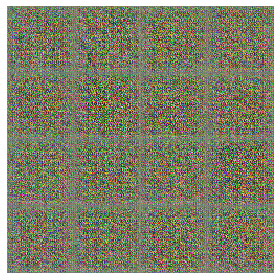

Disc: real loss: 1.522185 fake loss: 14.418458
GAN loss: 1.522185
Step 60 completed. Time took: 0 secs.
Begin step:  61
Disc: real loss: 1.488829 fake loss: 14.139118
GAN loss: 1.488829
Step 61 completed. Time took: 0 secs.
Begin step:  62
Disc: real loss: 1.747452 fake loss: 14.375976
GAN loss: 1.747452
Step 62 completed. Time took: 0 secs.
Begin step:  63
Disc: real loss: 1.588463 fake loss: 14.198252
GAN loss: 1.588463
Step 63 completed. Time took: 0 secs.
Begin step:  64
Disc: real loss: 1.707013 fake loss: 14.342507
GAN loss: 1.707013
Step 64 completed. Time took: 0 secs.
Begin step:  65
Disc: real loss: 1.697982 fake loss: 14.094721
GAN loss: 1.697982
Step 65 completed. Time took: 0 secs.
Begin step:  66
Disc: real loss: 1.708002 fake loss: 14.498915
GAN loss: 1.708002
Step 66 completed. Time took: 0 secs.
Begin step:  67
Disc: real loss: 1.546837 fake loss: 14.637988
GAN loss: 1.546837
Step 67 completed. Time took: 0 secs.
Begin step:  68
Disc: real loss: 1.606542 fake loss: 14.

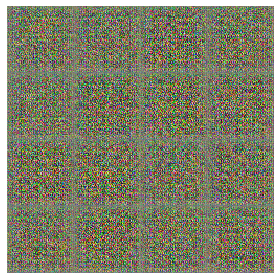

Disc: real loss: 1.565710 fake loss: 14.325221
GAN loss: 1.565710
Step 70 completed. Time took: 0 secs.
Begin step:  71
Disc: real loss: 1.754428 fake loss: 14.392865
GAN loss: 1.754428
Step 71 completed. Time took: 0 secs.
Begin step:  72
Disc: real loss: 1.567000 fake loss: 14.369693
GAN loss: 1.567000
Step 72 completed. Time took: 0 secs.
Begin step:  73
Disc: real loss: 1.541293 fake loss: 14.267660
GAN loss: 1.541293
Step 73 completed. Time took: 0 secs.
Begin step:  74
Disc: real loss: 1.538591 fake loss: 14.179444
GAN loss: 1.538591
Step 74 completed. Time took: 0 secs.
Begin step:  75
Disc: real loss: 1.695572 fake loss: 14.405679
GAN loss: 1.695572
Step 75 completed. Time took: 0 secs.
Begin step:  76
Disc: real loss: 1.797958 fake loss: 14.348806
GAN loss: 1.797958
Step 76 completed. Time took: 0 secs.
Begin step:  77
Disc: real loss: 1.662736 fake loss: 14.120449
GAN loss: 1.662736
Step 77 completed. Time took: 0 secs.
Begin step:  78
Disc: real loss: 1.476425 fake loss: 14.

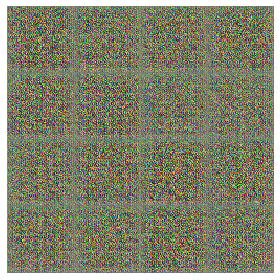

Disc: real loss: 1.498542 fake loss: 14.468742
GAN loss: 1.498542
Step 80 completed. Time took: 0 secs.
Begin step:  81
Disc: real loss: 1.662139 fake loss: 14.337731
GAN loss: 1.662139
Step 81 completed. Time took: 0 secs.
Begin step:  82
Disc: real loss: 1.464150 fake loss: 14.379589
GAN loss: 1.464150
Step 82 completed. Time took: 0 secs.
Begin step:  83
Disc: real loss: 1.657314 fake loss: 14.104706
GAN loss: 1.657314
Step 83 completed. Time took: 0 secs.
Begin step:  84
Disc: real loss: 1.530837 fake loss: 14.338900
GAN loss: 1.530837
Step 84 completed. Time took: 0 secs.
Begin step:  85
Disc: real loss: 1.644965 fake loss: 14.407089
GAN loss: 1.644965
Step 85 completed. Time took: 0 secs.
Begin step:  86
Disc: real loss: 1.704709 fake loss: 14.453362
GAN loss: 1.704709
Step 86 completed. Time took: 0 secs.
Begin step:  87
Disc: real loss: 1.488221 fake loss: 14.452534
GAN loss: 1.488221
Step 87 completed. Time took: 0 secs.
Begin step:  88
Disc: real loss: 1.652957 fake loss: 14.

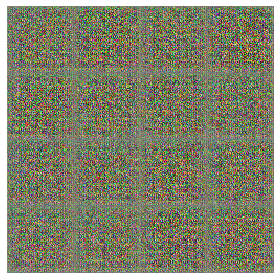

Disc: real loss: 1.619400 fake loss: 14.459332
GAN loss: 1.619400
Step 90 completed. Time took: 0 secs.
Begin step:  91
Disc: real loss: 1.533513 fake loss: 14.323694
GAN loss: 1.533513
Step 91 completed. Time took: 0 secs.
Begin step:  92
Disc: real loss: 1.528640 fake loss: 14.520628
GAN loss: 1.528640
Step 92 completed. Time took: 0 secs.
Begin step:  93
Disc: real loss: 1.619799 fake loss: 14.363314
GAN loss: 1.619799
Step 93 completed. Time took: 0 secs.
Begin step:  94
Disc: real loss: 1.672270 fake loss: 14.133362
GAN loss: 1.672270
Step 94 completed. Time took: 0 secs.
Begin step:  95
Disc: real loss: 1.697892 fake loss: 14.240299
GAN loss: 1.697892
Step 95 completed. Time took: 0 secs.
Begin step:  96
Disc: real loss: 1.570787 fake loss: 14.313121
GAN loss: 1.570787
Step 96 completed. Time took: 0 secs.
Begin step:  97
Disc: real loss: 1.515811 fake loss: 14.185335
GAN loss: 1.515811
Step 97 completed. Time took: 0 secs.
Begin step:  98
Disc: real loss: 1.494715 fake loss: 14.

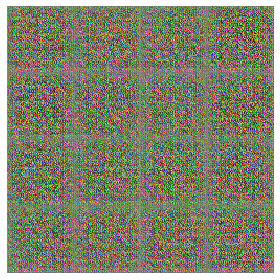

Disc: real loss: 1.653858 fake loss: 14.327239
GAN loss: 1.653858
Step 100 completed. Time took: 1 secs.
Begin step:  101
Disc: real loss: 1.661696 fake loss: 14.520470
GAN loss: 1.661696
Step 101 completed. Time took: 0 secs.
Begin step:  102
Disc: real loss: 1.685912 fake loss: 14.339174
GAN loss: 1.685912
Step 102 completed. Time took: 0 secs.
Begin step:  103
Disc: real loss: 1.595847 fake loss: 14.348084
GAN loss: 1.595847
Step 103 completed. Time took: 0 secs.
Begin step:  104
Disc: real loss: 1.624250 fake loss: 14.529661
GAN loss: 1.624250
Step 104 completed. Time took: 0 secs.
Begin step:  105
Disc: real loss: 1.661923 fake loss: 14.428800
GAN loss: 1.661923
Step 105 completed. Time took: 0 secs.
Begin step:  106
Disc: real loss: 1.583616 fake loss: 14.204535
GAN loss: 1.583616
Step 106 completed. Time took: 0 secs.
Begin step:  107
Disc: real loss: 1.484490 fake loss: 14.517283
GAN loss: 1.484490
Step 107 completed. Time took: 0 secs.
Begin step:  108
Disc: real loss: 1.56933

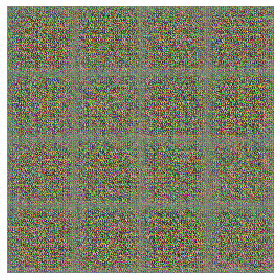

Disc: real loss: 1.709439 fake loss: 14.528517
GAN loss: 1.709439
Step 110 completed. Time took: 0 secs.
Begin step:  111
Disc: real loss: 1.661974 fake loss: 14.312002
GAN loss: 1.661974
Step 111 completed. Time took: 0 secs.
Begin step:  112
Disc: real loss: 1.712009 fake loss: 14.220353
GAN loss: 1.712009
Step 112 completed. Time took: 0 secs.
Begin step:  113
Disc: real loss: 1.483993 fake loss: 14.400729
GAN loss: 1.483993
Step 113 completed. Time took: 0 secs.
Begin step:  114
Disc: real loss: 1.605826 fake loss: 14.334735
GAN loss: 1.605826
Step 114 completed. Time took: 0 secs.
Begin step:  115
Disc: real loss: 1.457600 fake loss: 14.335149
GAN loss: 1.457600
Step 115 completed. Time took: 0 secs.
Begin step:  116
Disc: real loss: 1.835147 fake loss: 14.379530
GAN loss: 1.835147
Step 116 completed. Time took: 0 secs.
Begin step:  117
Disc: real loss: 1.701707 fake loss: 14.389139
GAN loss: 1.701707
Step 117 completed. Time took: 0 secs.
Begin step:  118
Disc: real loss: 1.70382

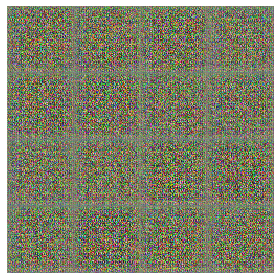

Disc: real loss: 1.768333 fake loss: 14.171659
GAN loss: 1.768333
Step 120 completed. Time took: 0 secs.
Begin step:  121
Disc: real loss: 1.575114 fake loss: 14.342010
GAN loss: 1.575114
Step 121 completed. Time took: 0 secs.
Begin step:  122
Disc: real loss: 1.680637 fake loss: 14.258141
GAN loss: 1.680637
Step 122 completed. Time took: 0 secs.
Begin step:  123
Disc: real loss: 1.813666 fake loss: 14.261909
GAN loss: 1.813666
Step 123 completed. Time took: 0 secs.
Begin step:  124
Disc: real loss: 1.543480 fake loss: 14.282944
GAN loss: 1.543480
Step 124 completed. Time took: 0 secs.
Begin step:  125
Disc: real loss: 1.590456 fake loss: 14.258095
GAN loss: 1.590456
Step 125 completed. Time took: 0 secs.
Begin step:  126
Disc: real loss: 1.623103 fake loss: 14.204836
GAN loss: 1.623103
Step 126 completed. Time took: 0 secs.
Begin step:  127
Disc: real loss: 1.578016 fake loss: 14.435637
GAN loss: 1.578016
Step 127 completed. Time took: 0 secs.
Begin step:  128
Disc: real loss: 1.64222

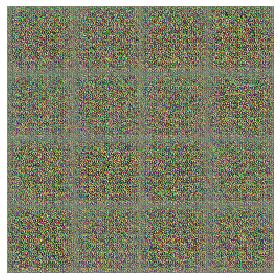

Disc: real loss: 1.720646 fake loss: 14.280961
GAN loss: 1.720646
Step 130 completed. Time took: 0 secs.
Begin step:  131
Disc: real loss: 1.570621 fake loss: 14.304562
GAN loss: 1.570621
Step 131 completed. Time took: 0 secs.
Begin step:  132
Disc: real loss: 1.612767 fake loss: 14.264130
GAN loss: 1.612767
Step 132 completed. Time took: 0 secs.
Begin step:  133
Disc: real loss: 1.581081 fake loss: 14.232504
GAN loss: 1.581081
Step 133 completed. Time took: 0 secs.
Begin step:  134
Disc: real loss: 1.519345 fake loss: 14.258464
GAN loss: 1.519345
Step 134 completed. Time took: 0 secs.
Begin step:  135
Disc: real loss: 1.608075 fake loss: 14.315610
GAN loss: 1.608075
Step 135 completed. Time took: 0 secs.
Begin step:  136
Disc: real loss: 1.582893 fake loss: 14.505306
GAN loss: 1.582893
Step 136 completed. Time took: 0 secs.
Begin step:  137
Disc: real loss: 1.504853 fake loss: 14.382554
GAN loss: 1.504853
Step 137 completed. Time took: 0 secs.
Begin step:  138
Disc: real loss: 1.50389

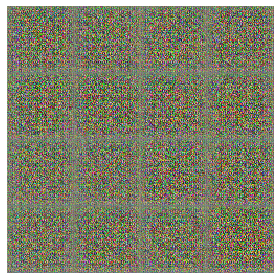

Disc: real loss: 1.394631 fake loss: 14.205143
GAN loss: 1.394631
Step 140 completed. Time took: 0 secs.
Begin step:  141
Disc: real loss: 1.515706 fake loss: 14.513946
GAN loss: 1.515706
Step 141 completed. Time took: 0 secs.
Begin step:  142
Disc: real loss: 1.537541 fake loss: 14.276013
GAN loss: 1.537541
Step 142 completed. Time took: 0 secs.
Begin step:  143
Disc: real loss: 1.553763 fake loss: 14.139448
GAN loss: 1.553763
Step 143 completed. Time took: 0 secs.
Begin step:  144
Disc: real loss: 1.556715 fake loss: 14.218093
GAN loss: 1.556715
Step 144 completed. Time took: 0 secs.
Begin step:  145
Disc: real loss: 1.680176 fake loss: 14.434700
GAN loss: 1.680176
Step 145 completed. Time took: 0 secs.
Begin step:  146
Disc: real loss: 1.525832 fake loss: 14.212025
GAN loss: 1.525832
Step 146 completed. Time took: 0 secs.
Begin step:  147
Disc: real loss: 1.633096 fake loss: 14.271130
GAN loss: 1.633096
Step 147 completed. Time took: 0 secs.
Begin step:  148
Disc: real loss: 1.52224

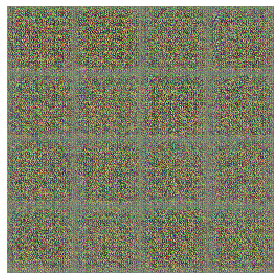

Disc: real loss: 1.621837 fake loss: 14.553646
GAN loss: 1.621837
Step 150 completed. Time took: 0 secs.
Begin step:  151
Disc: real loss: 1.577028 fake loss: 14.163136
GAN loss: 1.577028
Step 151 completed. Time took: 0 secs.
Begin step:  152
Disc: real loss: 1.592857 fake loss: 14.344400
GAN loss: 1.592857
Step 152 completed. Time took: 0 secs.
Begin step:  153
Disc: real loss: 1.559448 fake loss: 14.266110
GAN loss: 1.559448
Step 153 completed. Time took: 0 secs.
Begin step:  154
Disc: real loss: 1.565411 fake loss: 14.310362
GAN loss: 1.565411
Step 154 completed. Time took: 0 secs.
Begin step:  155
Disc: real loss: 1.386583 fake loss: 14.127781
GAN loss: 1.386583
Step 155 completed. Time took: 0 secs.
Begin step:  156
Disc: real loss: 1.570172 fake loss: 14.423385
GAN loss: 1.570172
Step 156 completed. Time took: 0 secs.
Begin step:  157
Disc: real loss: 1.745752 fake loss: 14.304519
GAN loss: 1.745752
Step 157 completed. Time took: 0 secs.
Begin step:  158
Disc: real loss: 1.67788

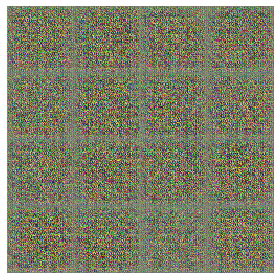

Disc: real loss: 1.509640 fake loss: 14.093160
GAN loss: 1.509640
Step 160 completed. Time took: 0 secs.
Begin step:  161
Disc: real loss: 1.628616 fake loss: 14.403856
GAN loss: 1.628616
Step 161 completed. Time took: 0 secs.
Begin step:  162
Disc: real loss: 1.481662 fake loss: 14.561117
GAN loss: 1.481662
Step 162 completed. Time took: 0 secs.
Begin step:  163
Disc: real loss: 1.820786 fake loss: 14.278591
GAN loss: 1.820786
Step 163 completed. Time took: 0 secs.
Begin step:  164
Disc: real loss: 1.853243 fake loss: 14.187013
GAN loss: 1.853243
Step 164 completed. Time took: 0 secs.
Begin step:  165
Disc: real loss: 1.565154 fake loss: 14.514869
GAN loss: 1.565154
Step 165 completed. Time took: 0 secs.
Begin step:  166
Disc: real loss: 1.440297 fake loss: 14.268366
GAN loss: 1.440297
Step 166 completed. Time took: 0 secs.
Begin step:  167
Disc: real loss: 1.486757 fake loss: 14.502966
GAN loss: 1.486757
Step 167 completed. Time took: 0 secs.
Begin step:  168
Disc: real loss: 1.52845

In [0]:
for step in range(num_steps): 
  total_step = step 
  print("Begin step: ", total_step)
  begin_time = time.time()
  real_data_X = sample_from_dataset(batch_size, image_shape, data_dir=data_dir)
  noise = gen_noise(batch_size, noise_shape)
  fake_data_X = generator.predict(noise)

  if (total_step % 10) == 0: 
    step_num = str(total_step).zfill(4)
    save_img_batch(fake_data_X, image_save_dir + step_num + '_image.jpg')
  
  ## Concatinate real and fake data samples 
  data_X = np.concatenate([real_data_X, fake_data_X])
  ## Add noise to the label inputs 
  real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size) * 0.2
  fake_data_Y = np.random.random_sample(batch_size) * 0.2
  data_Y = np.concatenate((real_data_Y, fake_data_Y))

  discriminator.trainable = True 
  generator.trainable = False
  disc_metric_real = discriminator.train_on_batch(real_data_X, real_data_Y)
  disc_metric_fake = discriminator.train_on_batch(fake_data_X, fake_data_Y)
  print("Disc: real loss: %f fake loss: %f" % (disc_metric_real[0], disc_metric_fake[0]))
  avg_disc_fake_loss.append(disc_metric_fake[0])
  avg_disc_real_loss.append(disc_metric_real[0])

  generator.trainable = True 
  GAN_X = gen_noise(batch_size, noise_shape)
  GAN_Y = real_data_Y
  discriminator.trainable = False
  gan_metrics = gan.train_on_batch(GAN_X,GAN_Y)
  print("GAN loss: %f" % (gan_metrics[0]))
  avg_GAN_loss.append(gan_metrics[0])
  end_time = time.time()
  diff_time = int(end_time - begin_time)
  print("Step %d completed. Time took: %s secs." % (total_step, diff_time))
  if ((total_step + 1) % 500) == 0:
    print("-----------------------------------------------------------------")
    print("Average Disc_fake loss: %f" % (np.mean(avg_disc_fake_loss)))    
    print("Average Disc_real loss: %f" % (np.mean(avg_disc_real_loss)))    
    print("Average GAN loss: %f" % (np.mean(avg_GAN_loss)))
    print("-----------------------------------------------------------------")
    discriminator.trainable = True
    generator.trainable = True
    generator.save(save_model_dir + str(total_step)+"_GENERATOR_weights_and_arch.hdf5")
    discriminator.save(save_model_dir + str(total_step)+"_DISCRIMINATOR_weights_and_arch.hdf5")